Using TensorFlow backend.
C:\Users\Tejas\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 63s - loss: 3974.7093 - val_loss: 2144.8538
Epoch 2/50
50000/50000 [==============================] - 61s - loss: 2148.0521 - val_loss: 2139.4617
Epoch 3/50
50000/50000 [==============================] - 61s - loss: 2123.7954 - val_loss: 2174.3137
Epoch 4/50
50000/50000 [==============================] - 62s - loss: 2143.6012 - val_loss: 2101.9033
Epoch 5/50
50000/50000 [==============================] - 61s - loss: 2090.3918 - val_loss: 2073.8547
Epoch 6/50
50000/50000 [==============================] - 59s - loss: 2193.2839 - val_loss: 2085.0769
Epoch 7/50
50000/50000 [==============================] - 56s - loss: 2092.1875 - val_loss: 2094.6724
Epoch 8/50
50000/50000 [==============================] - 69s - loss: 2086.9613 - val_loss: 2075.7393
Epoch 9/50
50000/50000 [==============================] - 72s - loss: 2087.1264 - val_loss: 2064.2078
Epoch 10/50
50000/50000 [=======

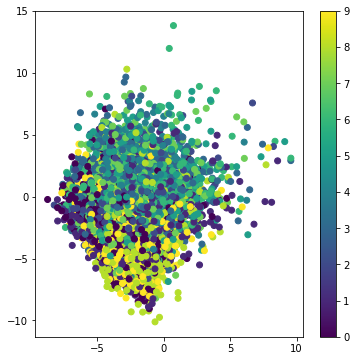

ValueError: cannot reshape array of size 3072 into shape (32,32)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10

batch_size = 10000
original_dim = 3072
latent_dim = 2
intermediate_dim = 1024
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on cifar10 images
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the 10 classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold
n = 15  # figure with 15x15
img_size = 32
figure = np.zeros((img_size * n, img_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))



In [5]:
 digit = x_decoded[0].reshape(img_size, img_size,3)

In [7]:
digit.shape

(32, 32, 3)

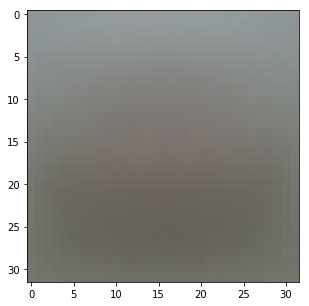

In [11]:
from matplotlib import pyplot as plt
from matplotlib import axes

fig = plt.figure(figsize = (5,5))
ax4 = fig.add_subplot(111)
ax4.imshow((digit), cmap = 'ocean')
#plt.plot([0,250],[137,137],'r-')

plt.show()